In [1]:
import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib

In [3]:
import pandas as pd
import numpy as np

In [4]:
DATA_DIR = pathlib.Path("data")

# Loading the data

In [5]:
!ls data

LD2011_2014.parquet


In [6]:
eldata = pd.read_parquet(DATA_DIR.joinpath("LD2011_2014.parquet"))

In [7]:
eldata.head()

,timestamp,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
eldata = eldata.resample("1H", on="timestamp").mean()

Text(0, 0.5, 'non-zero %')

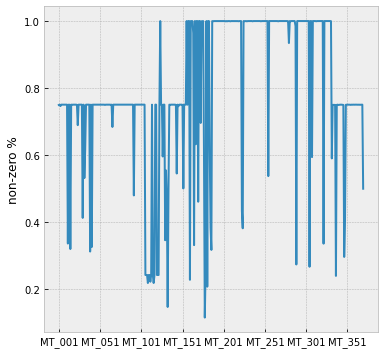

In [9]:
(eldata!=0).mean().plot()
plt.ylabel("non-zero %")

Text(0, 0.5, 'magnitude')

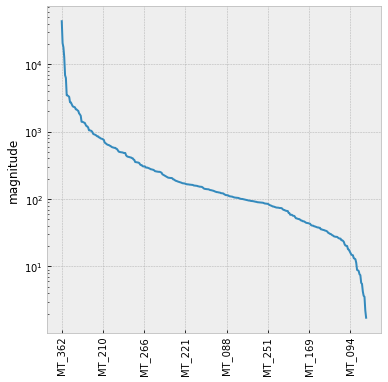

In [10]:
eldata[eldata!=0].median().sort_values(ascending=False).plot(rot=90)
plt.yscale("log")

plt.ylabel("magnitude")

# Dataset and DataModule

In [11]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

## Dataset

In [12]:
class ElectricityLoadDataset(Dataset):
    """Sample data from electricity load dataset (per household, resampled to one hour)."""

    def __init__(self, df, samples, hist_len=168, fct_len=24):
        self.hist_num = hist_len
        self.fct_num = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)
        self.samples = samples

        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
        self.raw_data = df.copy()

        assert samples <= self.raw_data[:self.max_ts].shape[0]

        self.sample()

    def sample(self):
        """Sample individual series as needed."""

        # Calculate actual start for each household
        self.clean_start_ts = (self.raw_data!=0).idxmax()

        households = []

        for hh in self.raw_data.columns:
            hh_start = self.clean_start_ts[hh]
            hh_nsamples = min(self.samples, self.raw_data.loc[hh_start:self.max_ts].shape[0])

            hh_samples = (self.raw_data
                          .loc[hh_start:self.max_ts]
                          .index
                          .to_series()
                          .sample(hh_nsamples, replace=False)
                          .index)
            households.extend([(hh, start_ts) for start_ts in hh_samples])

        self.samples = pd.DataFrame(households, columns=("household", "start_ts"))

        # Adding calendar features
        self.raw_data["yearly_cycle"] = np.sin(2 * np.pi * self.raw_data.index.dayofyear / 366)
        self.raw_data["weekly_cycle"] = np.sin(2 * np.pi * self.raw_data.index.dayofweek / 7)
        self.raw_data["daily_cycle"] = np.sin(2 * np.pi * self.raw_data.index.hour / 24)
        self.calendar_features = ["yearly_cycle", "weekly_cycle", "daily_cycle"]

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        household, start_ts = self.samples.iloc[idx]

        hs, he = start_ts, start_ts + self.hist_len - self.offset
        fs, fe = he + self.offset, he + self.fct_len

        hist_data = self.raw_data.loc[hs:, [household] + self.calendar_features].iloc[:self.hist_num]
        fct_data = self.raw_data.loc[fs:, [household] + self.calendar_features].iloc[:self.fct_num]

        return (torch.Tensor(hist_data.values),
                torch.Tensor(fct_data.values))

In [13]:
ds = ElectricityLoadDataset(eldata, 100)

In [14]:
hist, fct = ds[4]

### Check correct length

In [15]:
hist.shape

torch.Size([168, 4])

In [16]:
fct.shape

torch.Size([24, 4])

### Check number of samples per household

In [17]:
ds.samples.groupby("household").size().unique()

array([100])

## DataModule

In [18]:
class ElectricityLoadDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df,
                 train=0.7, 
                 val=0.2,
                 test=0.1,
                 samples=100,
                 batch_size=64,
                 workers=3):

        super().__init__()

        assert train + val + test <= 1

        self.raw_data = df
        self.train_size = int(train * df.shape[1])
        self.val_size = int(val * df.shape[1])
        self.test_size = df.shape[1] - self.train_size - self.val_size

        self.samples = samples
        self.batch_size = batch_size
        self.workers = workers
        self.split()

    def split(self):
        hh_rand = (self.raw_data
                   .columns
                   .to_series()
                   .sample(self.raw_data.shape[1],
                           replace=False))

        self.train_hh = hh_rand.iloc[:self.train_size].index
        self.val_hh = hh_rand.iloc[self.train_size:(self.val_size + self.train_size)].index
        self.test_hh = hh_rand.iloc[-self.test_size:].index

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[self.train_hh]
            val_df = self.raw_data[self.val_hh]

            self.train_ds = ElectricityLoadDataset(train_df,
                                                   samples=self.samples)
            self.val_ds = ElectricityLoadDataset(val_df,
                                                 samples=self.samples)

        if stage == "test" or stage is None:
            test_df = self.raw_data[self.test_hh]
            self.test_ds = ElectricityLoadDataset(test_df,
                                              samples=self.samples)

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

In [19]:
dm = ElectricityLoadDataModule(eldata)
dm.setup()

In [20]:
assert dm.train_hh.intersection(dm.val_hh).empty
assert dm.train_hh.intersection(dm.test_hh).empty
assert dm.train_hh.size + dm.val_hh.size + dm.test_hh.size == 370

In [21]:
x, y = next(iter(dm.train_dataloader()))

In [22]:
x.shape, y.shape

(torch.Size([64, 168, 4]), torch.Size([64, 24, 4]))

# Model

In [27]:
class ElectricityLoadModel(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, input_size=4, num_layers=1, hidden_units=8, lr=1e-3):
        super().__init__()

        self.hist_len = hist_len
        self.fct_len = fct_len
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.lr = lr

        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_units,
                            num_layers=self.num_layers,
                            batch_first=True)

        self.mu = nn.Linear(in_features=self.hidden_units, out_features=1)
        self.sigma_raw = nn.Linear(in_features=self.hidden_units, out_features=1)
        self.sigma = nn.Softplus()

    def forward(self, x, hidden=None):
        output, (hh, cc) = self.lstm(x)
        mu = self.mu(output)
        sigma = self.sigma(self.sigma_raw(output))
        return output, mu, sigma, hh, cc

    def training_step(self, batch, batch_idx):
        combined_input = torch.cat(batch, dim=1)

        # Pushing through the network
        out, mu, sigma, hh, cc = self(combined_input[:, :-1, :])

        return self.loss(mu, sigma, combined_input[:, 1:, [0]])

    def validation_step(self, batch, batch_idx):

        combined_input = torch.cat(batch, dim=1)

        # Pushing through the network
        out, mu, sigma, hh, cc = self(combined_input[:, :-1, :])

        loss = self.loss(mu, sigma, combined_input[:, 1:, [0]])
        self.log('val_logprob', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def sample(self, x, samples):
        # Handle single stream or multiple streams
        x = x.view(-1, self.hist_len, 4)

        # Initial pass - `mu(T+1)` and `sigma(T+1)` are ready
        out, mu, sigma, hh_initial, cc_initial = self(x)

        # Sample from the distribution
        gaussian = torch.distributions.normal.Normal(mu[:, -1, -1], sigma[:, -1, -1])
        initial_sample = gaussian.sample((samples,))

        # Getting calendar features
        calendar_features = x[:, -self.fct_len:, 1:]
        
        all_samples = []

        # Iterating over samples
        for sample in range(samples):
            current_sample = initial_sample[sample]

            # We want output to be `(fct_len, batch_size, samples)`
            local_samples = [current_sample.view(1, -1, 1)]
            
            # Initialize hidden and cell state to encoder output
            hh, cc = hh_initial, cc_initial

            # Iterating over time steps
            for step in range(self.fct_len - 1):

                # Input tensor for this step
                step_in = torch.cat([current_sample.view(-1, 1, 1),
                                     calendar_features[:, [step], :]], dim=-1)

                step_out, mu, sigma, hh, cc = self(step_in, (hh, cc))

                # Sampling the next step value
                gaussian = torch.distributions.normal.Normal(mu[:, -1, -1], sigma[:, -1, -1])
                current_sample = gaussian.sample((1,))
                
                # Storing the samples for this time step
                local_samples.append(current_sample.unsqueeze(-1))

            # Storing all samples for this sample
            all_samples.append(torch.cat(local_samples, dim=0))
        return torch.cat(all_samples, -1)

    def loss(self, mu, sigma, y):
        # Distribution with generated `mu` and `sigma`
        gaussian = torch.distributions.normal.Normal(mu, sigma)

        # Log-likelihood
        L = gaussian.log_prob(y)

        return -torch.mean(L)

# Training

In [28]:
scaled_data = eldata / eldata[eldata!=0].mean() - 1

In [29]:
dm = ElectricityLoadDataModule(scaled_data, batch_size=128)
model = ElectricityLoadModel(lr=1e-3, hidden_units=64, num_layers=1)
trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=1, gpus=1)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | lstm      | LSTM     | 17.9 K
1 | mu        | Linear   | 65    
2 | sigma_raw | Linear   | 65    
3 | sigma     | Softplus | 0     
---------------------------------------
18.1 K    Trainable params
0         Non-trainable params
18.1 K    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

# Example forecasts

Although the model must be trained in full longer and with larger number of layers, we still can capture the logistics of making the forecasts:

In [30]:
dm.setup(stage="test")

In [31]:
batch = next(iter(dm.test_dataloader()))

In [32]:
X, y = batch

In [34]:
result = model.sample(X, 100)

In [35]:
result.shape

torch.Size([24, 128, 100])

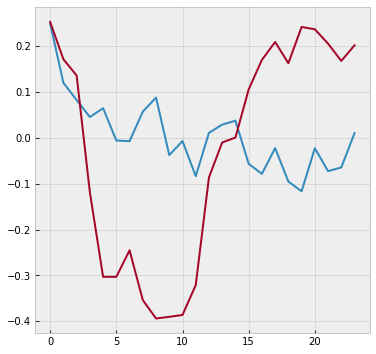

In [38]:
plt.plot(result.mean(dim=-1).numpy()[:,8])
plt.plot(y[8, :, 0])